In [87]:
!pip install pydicom
#!pip install glob
#!pip install pylab
import pandas as pd
import numpy as np
import os
import pydicom,cv2,pylab
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import pydicom as dcm

In [0]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all'

In [88]:
from google.colab import drive
drive.mount('./content/')


Drive already mounted at ./content/; to attempt to forcibly remount, call drive.mount("./content/", force_remount=True).


In [0]:
project_path = ".//content//My Drive//"


In [90]:
project_path

'.//content//My Drive//'

In [0]:
#Unzipping project folder
from zipfile import ZipFile
with ZipFile(project_path+'rsna-pneumonia-detection-challenge.zip', 'r') as z:
  z.extractall()

# LOADING THE LABELED SET

In [0]:
#Accessing detailed class information 
class_info_df = pd.read_csv('stage_2_detailed_class_info.csv')

In [93]:
class_info_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [94]:
class_info_df.describe()

,patientId,class
count,30227,30227
unique,26684,3
top,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,No Lung Opacity / Not Normal
freq,4,11821


- There are 26684 Number of unique patients.  The class info has more number of counts, as a patient can have more than one bounding box

- Unique classes are 3, out of these 11821 patients have No Lung Opacity/Not Normal classification which is the top most occurance of the 3 class

- Patient name is repeated maximum 4 times in the class info data

In [0]:
#Accessing train labels
train_labels_df = pd.read_csv('stage_2_train_labels.csv')

In [96]:
train_labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [97]:
train_labels_df.describe(include = 'all')

,patientId,x,y,width,height,Target
count,30227,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
unique,26684,NaN,NaN,NaN,NaN,NaN
top,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,NaN,NaN,NaN,NaN,NaN
freq,4,NaN,NaN,NaN,NaN,NaN
mean,NaN,394.047724,366.839560,218.471376,329.269702,0.316108
std,NaN,204.574172,148.940488,59.289475,157.750755,0.464963
min,NaN,2.000000,2.000000,40.000000,45.000000,0.000000
25%,NaN,207.000000,249.000000,177.000000,203.000000,0.000000
50%,NaN,324.000000,365.000000,217.000000,298.000000,0.000000
75%,NaN,594.000000,478.500000,259.000000,438.000000,1.000000


In [100]:
train_labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [107]:
train_labels_df_areas = train_labels_df.dropna()[['x', 'y', 'width', 'height']].copy()
train_labels_df_areas['x_2'] = train_labels_df_areas['x'] + train_labels_df_areas['width']
train_labels_df_areas['y_2'] = train_labels_df_areas['y'] + train_labels_df_areas['height']
train_labels_df_areas['x_center'] = train_labels_df_areas['x'] + train_labels_df_areas['width'] / 2
train_labels_df_areas['y_center'] = train_labels_df_areas['y'] + train_labels_df_areas['height'] / 2
train_labels_df_areas['area'] = train_labels_df_areas['width'] * train_labels_df_areas['height']

train_labels_df_areas.head()

,x,y,width,height,x_2,y_2,x_center,y_center,area
4,264.0,152.0,213.0,379.0,477.0,531.0,370.5,341.5,80727.0
5,562.0,152.0,256.0,453.0,818.0,605.0,690.0,378.5,115968.0
8,323.0,577.0,160.0,104.0,483.0,681.0,403.0,629.0,16640.0
9,695.0,575.0,162.0,137.0,857.0,712.0,776.0,643.5,22194.0
14,288.0,322.0,94.0,135.0,382.0,457.0,335.0,389.5,12690.0


In [181]:
train_labels_df_areas.describe()

,x,y,width,height,x_2,y_2,x_center,y_center,area
count,9555.000000,9555.000000,9555.000000,9555.000000,9555.000000,9555.000000,9555.000000,9555.000000,9555.000000
mean,394.047724,366.839560,218.471376,329.269702,612.519100,696.109262,503.283412,531.474411,77523.448038
std,204.574172,148.940488,59.289475,157.750755,209.625208,129.391106,204.982559,115.071015,51807.689206
min,2.000000,2.000000,40.000000,45.000000,147.000000,214.000000,87.500000,130.000000,2320.000000
25%,207.000000,249.000000,177.000000,203.000000,423.500000,614.000000,314.500000,455.000000,37535.500000
50%,324.000000,365.000000,217.000000,298.000000,519.000000,705.000000,415.000000,531.000000,64829.000000
75%,594.000000,478.500000,259.000000,438.000000,821.000000,785.000000,709.000000,609.000000,106491.500000
max,835.000000,881.000000,528.000000,942.000000,1024.000000,1024.000000,899.500000,945.000000,371184.000000


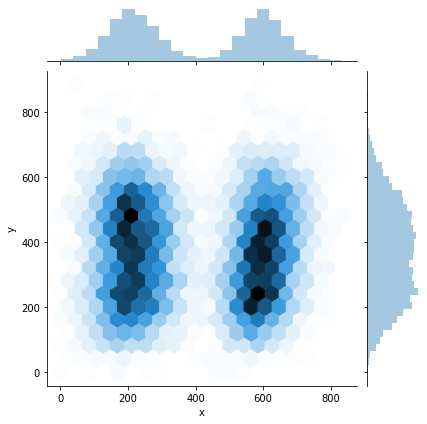

In [108]:
sns.jointplot(x = 'x', y = 'y', data = train_labels_df_areas, kind = 'hex', gridsize = 20);

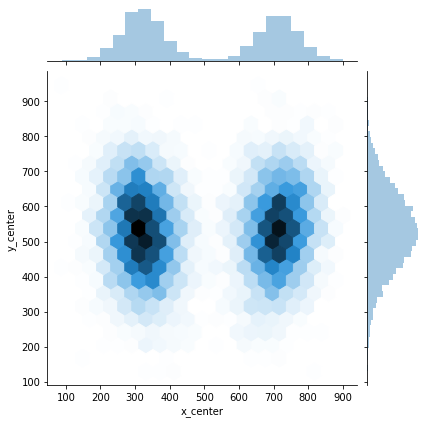

In [109]:
sns.jointplot(x = 'x_center', y = 'y_center', data = train_labels_df_areas, kind = 'hex', gridsize = 20);

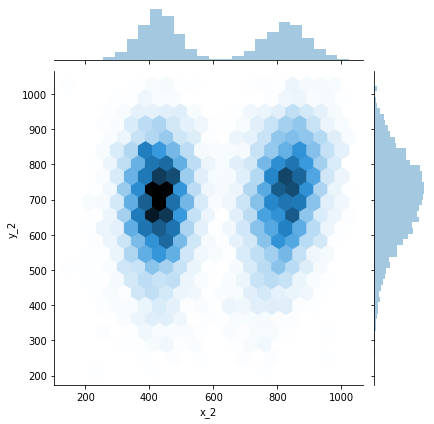

In [111]:
sns.jointplot(x = 'x_2', y = 'y_2', data = train_labels_df_areas, kind = 'hex', gridsize = 20)

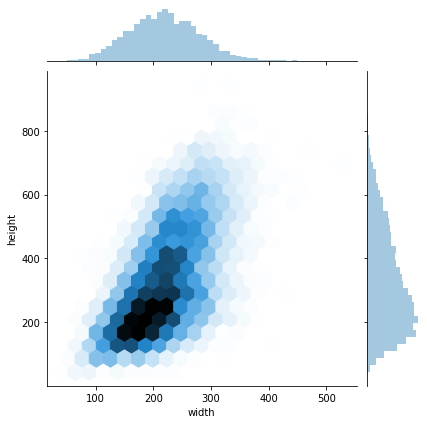

In [112]:
sns.jointplot(x = 'width', y = 'height', data = train_labels_df_areas, kind = 'hex', gridsize = 20)

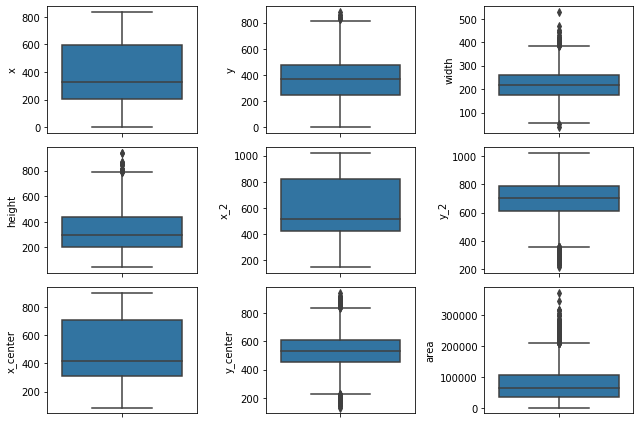

In [114]:
n_columns = 3
n_rows = 3
_, axes = plt.subplots(n_rows, n_columns, figsize=(3 * n_columns, 2 * n_rows))
for i, c in enumerate(train_labels_df_areas.columns):
    sns.boxplot(y = c, data = train_labels_df_areas, ax = axes[i // n_columns, i % n_columns])
plt.tight_layout()
plt.show()

In [183]:
Q1 = train_labels_df_areas.quantile(0.25)
Q3 = train_labels_df_areas.quantile(0.75)
IQR = Q3 - Q1
IQR

x             387.0
y             229.5
width          82.0
height        235.0
x_2           397.5
y_2           171.0
x_center      394.5
y_center      154.0
area        68956.0
dtype: float64

In [0]:
# 

- Lets fix threshold of height = 500 and width = 900 for deleting patient data, so that minimum patient data is lost in the process

In [188]:
train_labels_df[train_labels_df['width']>500]

,patientId,x,y,width,height,Target
678,097788d4-cb88-4457-8e71-0ca7a3da2216,226.0,189.0,528.0,703.0,1


In [191]:
train_labels_df[train_labels_df['height']>900]

,patientId,x,y,width,height,Target
4098,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,549.0,82.0,280.0,942.0,1
4358,3e62e51c-befb-4a66-b28e-fc469b19e4a8,620.0,82.0,335.0,942.0,1


In [189]:
pid_width = list(train_labels_df[train_labels_df['width'] > 500]['patientId'].values)
train_labels_df[train_labels_df['patientId'].isin(pid_width)]

,patientId,x,y,width,height,Target
678,097788d4-cb88-4457-8e71-0ca7a3da2216,226.0,189.0,528.0,703.0,1


In [190]:
pid_height = list(train_labels_df[train_labels_df['height'] > 900]['patientId'].values)
train_labels_df[train_labels_df['patientId'].isin(pid_)]

,patientId,x,y,width,height,Target
4097,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,87.0,104.0,310.0,793.0,1
4098,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,549.0,82.0,280.0,942.0,1
4357,3e62e51c-befb-4a66-b28e-fc469b19e4a8,148.0,87.0,366.0,867.0,1
4358,3e62e51c-befb-4a66-b28e-fc469b19e4a8,620.0,82.0,335.0,942.0,1


In [0]:
train_labels_df = train_labels_df[~train_labels_df['patientId'].isin(pid_width + pid_height)]
train_labels_df.shape

(30222, 6)

- Since all the outliers are related to Target = 1 we willnot delete any data, as the model requires their image data for classification

### Checking Missing values 

In [0]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))

In [0]:
missing_data(train_labels_df)

,height,width,y,x,Target,patientId
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


- The persons who are negative to pnuemonia,  doesnot have co-ordinates of bounding box defined in their X-rays.  Hence, they are appearing as missing values

In [0]:
missing_data(class_info_df)

,class,patientId
Total,0.0,0.0
Percent,0.0,0.0


- All patients are classified as one or the other 3 classes viz., Lung Opacity, Normal and No Lung Opacity/Not Normal

In [0]:
# Concatinating both the class info and train dataset into single dataframe
train_class_df = pd.concat([train_labels_df, class_info_df.drop('patientId',1)], axis = 1)

In [0]:
train_class_df.shape

(30227, 7)

In [0]:
tmp = train_class_df.groupby(['patientId','Target', 'class'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target','class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Exams', 'Target','Class', 'Entries']
df2

,Exams,Target,Class,Entries
0,1,0,No Lung Opacity / Not Normal,11821
1,1,0,Normal,8851
2,1,1,Lung Opacity,2614
3,2,1,Lung Opacity,3266
4,3,1,Lung Opacity,119
5,4,1,Lung Opacity,13


- There are 2614 number of patients with single bounding box, 3266 patients with 2 bounding boxes, 119 patients with 3 bounding boxes and 13 patients with 4 bounding boxes

- 20672 patients are negative to pneumonia and 6012 are positive to pneumonia

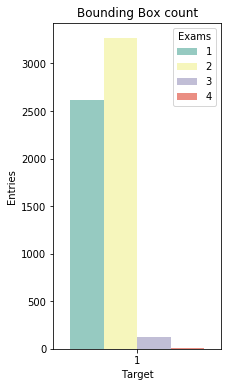

In [0]:
fig, ax = plt.subplots(nrows=1,figsize=(3,6))
sns.barplot(ax=ax,x = 'Target', y='Entries', hue='Exams',data=df2[df2['Target'] == 1], palette='Set3')
plt.title("Bounding Box count")
plt.show()

# ACCESSING DATA FROM DCOM FILE FOR EDA


In [0]:
#Accessing one of the patient data stored in DICOM file
patientId =train_labels_df['patientId'][10]
dcm_file = 'stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.17654.1517874405.352989
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '008c19e8-a820-403a-930a-bc74a4053664'
(0010, 0020) Patient ID                          LO: '008c19e8-a820-403a-930a-bc74a4053664'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [0]:
#Pixel data of the X-ray taken 
dcm_data.pixel_array

array([[ 36,  33,  29, ..., 144, 142, 142],
       [ 35,  31,  28, ..., 139, 139, 140],
       [ 33,  30,  27, ..., 138, 140, 141],
       ...,
       [ 23,  23,  23, ..., 121, 121, 124],
       [ 25,  25,  25, ..., 122, 121, 124],
       [ 27,  27,  26, ..., 123, 122, 123]], dtype=uint8)

UPDATING PATIENT DATA FROM DCOM FILE

In [0]:
#Copying train_labels for adding data from DICOM file
data_train_labels = train_class_df.copy()

In [0]:
#Accessing Age, Gender, Posiiton, Rows and Columns of X-ray from DICOM
Age = []
Gender = []
Position = []
dicom = []
Rows = []
Columns = []
Modality = []
ConversionType = []
Compression = []
CompressionMethod = []
BodyExamined = []
SamplesPerPixel = []
for i,row in train_labels_df.iterrows():
  patientId =train_labels_df['patientId'][i]
  dicom = 'stage_2_train_images/%s.dcm' % patientId
  dcm_data = pydicom.read_file(dicom)
  Age.append(dcm_data.PatientAge)
  Gender.append(dcm_data.PatientSex)
  Position.append(dcm_data.ViewPosition)
  Rows.append(dcm_data.Rows)
  Columns.append(dcm_data.Columns)
  Modality.append(dcm_data.Modality)
  ConversionType.append(dcm_data.ConversionType)
  Compression.append(dcm_data.LossyImageCompression)
  CompressionMethod.append(dcm_data.LossyImageCompressionMethod)
  BodyExamined.append(dcm_data.BodyPartExamined)
  SamplesPerPixel.append(dcm_data.SamplesPerPixel)


  


In [0]:
#Adding Age, Gender and Position to the dataframe of train labels
data_train_labels['Age'] = Age
data_train_labels['Gender'] = Gender
data_train_labels['View Position'] = Position
data_train_labels['Rows'] = Rows
data_train_labels['Columns'] = Columns
data_train_labels['Modalaity'] = Modality
data_train_labels['ConversionType'] = ConversionType
data_train_labels['Compression'] = Compression
data_train_labels['CompressionMethod'] = CompressionMethod
data_train_labels['BodyExamined'] = BodyExamined
data_train_labels['SamplesPerPixel'] = SamplesPerPixel

In [0]:
data_train_labels.describe(include =  'all')

,patientId,x,y,width,height,Target,class,Age,Gender,View Position,Rows,Columns,Modalaity,ConversionType,Compression,CompressionMethod,BodyExamined,SamplesPerPixel
count,30227,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000,30227,30227,30227,30227,30227.0,30227.0,30227,30227,30227,30227,30227,30227.0
unique,26684,NaN,NaN,NaN,NaN,NaN,3,97,2,2,NaN,NaN,1,1,1,1,1,NaN
top,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,NaN,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,58,M,AP,NaN,NaN,CR,WSD,01,ISO_10918_1,CHEST,NaN
freq,4,NaN,NaN,NaN,NaN,NaN,11821,955,17216,15297,NaN,NaN,30227,30227,30227,30227,30227,NaN
mean,NaN,394.047724,366.839560,218.471376,329.269702,0.316108,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,NaN,NaN,1.0
std,NaN,204.574172,148.940488,59.289475,157.750755,0.464963,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
min,NaN,2.000000,2.000000,40.000000,45.000000,0.000000,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,NaN,NaN,1.0
25%,NaN,207.000000,249.000000,177.000000,203.000000,0.000000,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,NaN,NaN,1.0
50%,NaN,324.000000,365.000000,217.000000,298.000000,0.000000,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,NaN,NaN,1.0
75%,NaN,594.000000,478.500000,259.000000,438.000000,1.000000,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,NaN,NaN,1.0


- The values of rows and columns has only a single value of 1024 x 1024.  Hence, it can be concluded that all x-rays are of equal size of 1024 x 1024

- Modality, SamplesPerPixel, ConversionType, Compression, CompressionMethod and BodyExamined all have only 1 unique value for all patients.  As there are common for all patients, they are not taken farward to modelling

In [0]:
#Converting 'Age' into integer 
convert_dict = {'Age':int}
data_train_labels = data_train_labels.astype(convert_dict)

### Defining Dictionary of Data for modelling

In [0]:
#Defing function to obtain dictionary of Patient data
def Final_data(df):
    
    # Define lambda to extract coords in list [x, y, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    Patient_data = {}
    Age = []
    Gender = []
    Position = []
    for n, row in df.iterrows():
        # Initialize patient entry into parsed 
        pid = row['patientId']
        dcm_file = 'stage_2_train_images/%s.dcm' % patientId
        dcm_data = pydicom.read_file(dcm_file)
        if pid not in Patient_data:
            Patient_data[pid] = {
                                'Age'         : row['Age'],
                                'Gender'      : row['Gender'],
                                'Position'    : row['View Position'],
                                'dicom'       : './stage_2_train_images/%s.dcm' % pid,
                                'class'       : row['class'],
                               # 'Pixel_array' : dcm_data.pixel_array,
                                'label'       : row['Target'],
                                'boxes'       : []
                                 }

        #  Add box if opacity is present as bounding boxes are defined only when Target is 1
        if Patient_data[pid]['label'] == 1:
            Patient_data[pid]['boxes'].append(extract_box(row))

    return Patient_data

In [0]:
# Converting the modified train_labels and dicom data into a dictionary
Patient_data = Final_data(data_train_labels)

In [120]:
#Accessing patient data with patient ID index
print(Patient_data[data_train_labels['patientId'][4]])


{'Age': 32, 'Gender': 'F', 'Position': 'AP', 'dicom': './stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'class': 'Lung Opacity', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


In [121]:
#Accessing patient data with patient ID
print(Patient_data['1bf08f3b-a273-4f51-bafa-b55ada2c23b5']['dicom'])

./stage_2_train_images/1bf08f3b-a273-4f51-bafa-b55ada2c23b5.dcm


# GENERATING DATA FOR EXPLORATORY DATA ANAYLYSIS

In [0]:
final_df = pd.DataFrame.from_dict(Patient_data, orient = 'index').reset_index()

In [0]:
final_df.rename(columns = {'index':'patientId'},inplace = True)

In [124]:
final_df.head(10)

,patientId,Age,Gender,Position,dicom,class,label,boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F,PA,./stage_2_train_images/0004cfab-14fd-4e49-80ba...,No Lung Opacity / Not Normal,0,[]
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,48,F,PA,./stage_2_train_images/00313ee0-9eaa-42f4-b0ab...,No Lung Opacity / Not Normal,0,[]
2,00322d4d-1c29-4943-afc9-b6754be640eb,19,M,AP,./stage_2_train_images/00322d4d-1c29-4943-afc9...,No Lung Opacity / Not Normal,0,[]
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,28,M,PA,./stage_2_train_images/003d8fa0-6bf1-40ed-b54c...,Normal,0,[]
4,00436515-870c-4b36-a041-de91049b9ab4,32,F,AP,./stage_2_train_images/00436515-870c-4b36-a041...,Lung Opacity,1,"[[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, ..."
5,00569f44-917d-4c86-a842-81832af98c30,54,M,AP,./stage_2_train_images/00569f44-917d-4c86-a842...,No Lung Opacity / Not Normal,0,[]
6,006cec2e-6ce2-4549-bffa-eadfcd1e9970,78,M,PA,./stage_2_train_images/006cec2e-6ce2-4549-bffa...,No Lung Opacity / Not Normal,0,[]
7,00704310-78a8-4b38-8475-49f4573b2dbb,75,M,PA,./stage_2_train_images/00704310-78a8-4b38-8475...,Lung Opacity,1,"[[577.0, 323.0, 104.0, 160.0], [575.0, 695.0, ..."
8,008c19e8-a820-403a-930a-bc74a4053664,59,F,PA,./stage_2_train_images/008c19e8-a820-403a-930a...,No Lung Opacity / Not Normal,0,[]
9,009482dc-3db5-48d4-8580-5c89c4f01334,63,M,PA,./stage_2_train_images/009482dc-3db5-48d4-8580...,Normal,0,[]


In [125]:
patientId = train_class_df['patientId'][3]
patientId
final_df.loc[3]['Age']

28

# VARIABLE COUNTS

### Gender

In [126]:
# Gender count
Female = np.sum(final_df['Gender'] == 'F')
Male = np.sum(final_df['Gender'] == 'M')
print('Total number of Female Patients : %d' %Female)
print('Total number of Male Patients : %d' %Male)

Total number of Female Patients : 11518
Total number of Male Patients : 15166


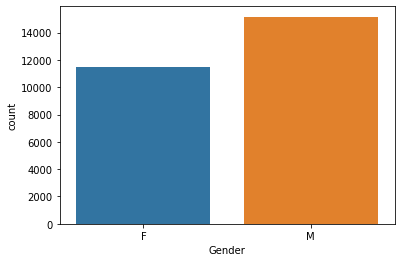

In [127]:
sns.countplot(final_df['Gender'])

Out of 26884 X-rays, there are 11518 of female and 15166 of male chest X-rays


In [128]:
Female_patients = np.sum((final_df['Gender'] == 'F') & (final_df['label'] == 1))/np.sum(final_df['Gender'] == 'F')
Female_patients

0.21722521271054002

- Out of the total female patients 21.7% are positive to pneumonia

In [129]:
Male_patients = np.sum((final_df['Gender'] == 'M') & (final_df['label'] == 1))/np.sum(final_df['Gender'] == 'M')
Male_patients

0.23143874456020044

- Out of Total male patients 23.148% are positive to pneumonia

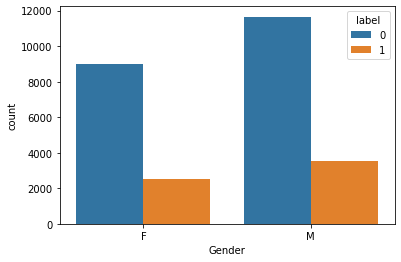

In [130]:
# Distribution of target label with Gender
sns.countplot(final_df['Gender'], hue = final_df['label'])


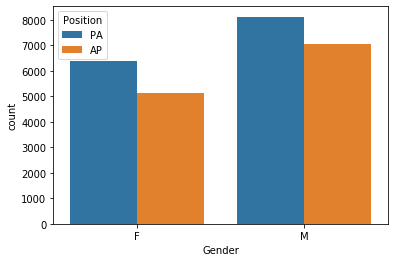

In [131]:
sns.countplot(final_df['Gender'], hue = final_df['Position'])

- More patients have 'PA' X-ray images than 'AP

### Target variable

In [132]:
Positive = np.sum(final_df['label'] == 1)
Negative = np.sum([final_df['label'] == 0])
print('Total Positive Pneumonia cases : %d' %Positive)
print('Total Negative Pneumonia cases : %d' %Negative)

Total Positive Pneumonia cases : 6012
Total Negative Pneumonia cases : 20672


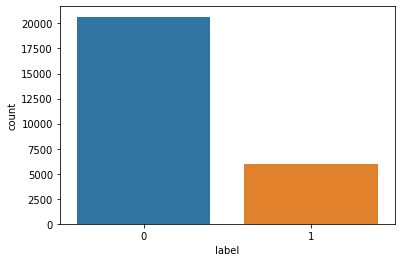

In [133]:
sns.countplot(final_df['label'])

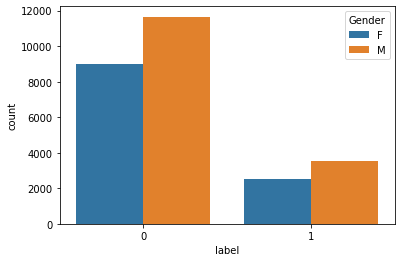

In [134]:
sns.countplot(final_df['label'], hue = final_df['Gender'])

In [135]:
positive_female = np.sum((final_df['Gender'] == 'F') & (final_df['label'] == 1))/np.sum(final_df['label'] == 1)
positive_female

0.4161676646706587

- Out of total pnumonia patients 41.6& are Female




In [136]:
positive_male = np.sum((final_df['Gender'] == 'M') & (final_df['label'] == 1))/np.sum(final_df['label'] == 1)
positive_male

0.5838323353293413

- Out of total pnuemonia patients 58.3% are Male

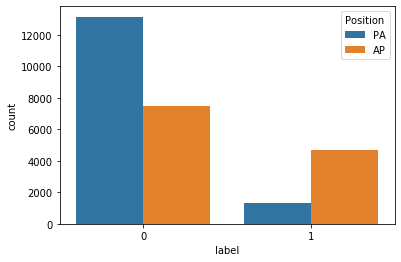

In [137]:
sns.countplot(final_df['label'], hue = final_df['Position'])

### X-ray Position count

In [138]:
#final_df[final_df['Position'] == 'PA'].count()
pa = np.sum(final_df['Position'] == 'PA')
ap = np.sum(final_df['Position'] == 'AP')
print('Back to Front X-rays PA : %d' %pa)
print('Front to Back X-rays AP : %d' %ap)

Back to Front X-rays PA : 14511
Front to Back X-rays AP : 12173


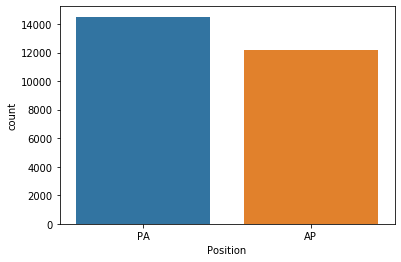

In [139]:
sns.countplot(final_df['Position'])

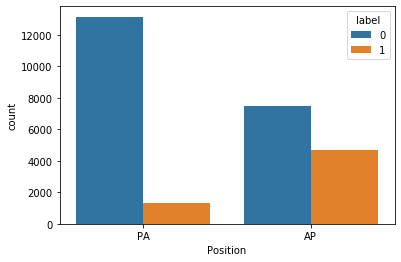

In [140]:
sns.countplot(final_df['Position'], hue = final_df['label'])

In [141]:
positive_ap = np.sum((final_df['Position'] == 'AP') & (final_df['label'] == 1))/np.sum(final_df['label'] == 1)
positive_ap

0.7757817697937458

- Of the total positive pnuemonia patients, 77.57% are found to have 'AP' position X-ray

In [142]:
pa = np.sum((final_df['Position'] == 'PA') & (final_df['label'] == 1))/np.sum(final_df['Position'] == 'PA')
pa

0.09289504513817104

- Only 9.28% of the patients whose X-rays are taken from Posterior to Anterior are diagnized with Pneumonia

In [143]:
ap = np.sum((final_df['Position'] == 'AP') & (final_df['label'] == 1))/np.sum(final_df['Position'] == 'AP')
ap

0.3831430214408938

- 38.3% of the patients whose X-rays are taken from Anterior to Posterior are diagnized with Pneumonia

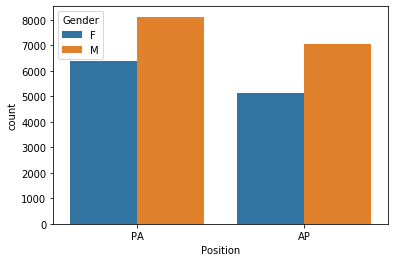

In [144]:
sns.countplot(final_df['Position'], hue = final_df['Gender'])

In [145]:
pa_female = np.sum((final_df['Position'] == 'PA') & (final_df['Gender'] == 'F'))/np.sum(final_df['Position'] == 'PA')
pa_female

0.44042450554751567

In [146]:
ap_female = np.sum((final_df['Position'] == 'AP') & (final_df['Gender'] == 'F'))/np.sum(final_df['Position'] == 'AP')
ap_female

0.4211780169226978

- The distribution of male and female among 'PA' and 'AP' position is almost same with patients diagonized in 'PA' position being more

### Count of 'Class' Distribution

In [147]:
final_df.groupby(['class', 'label']).size().reset_index(name='Patient Count')

,class,label,Patient Count
0,Lung Opacity,1,6012
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


Distribution of class with respect to Target.  It can be seen that the No Lung Opacity/Not Normal cases are more

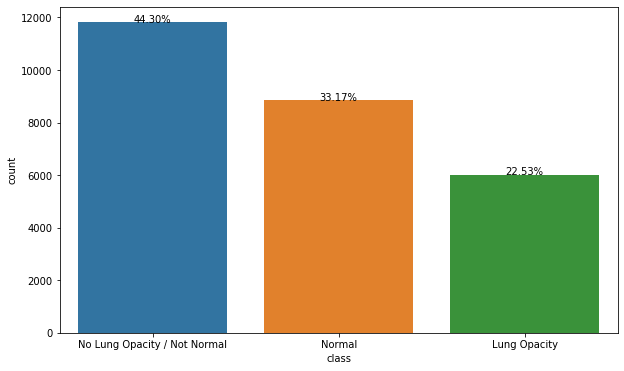

In [148]:

f, ax = plt.subplots(1,1, figsize=(10,6))
total = float(len(final_df))
sns.countplot(final_df['class'],order = final_df['class'].value_counts().index)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

# DISTRIBUTION AND RELATIONSHIP PLOTS

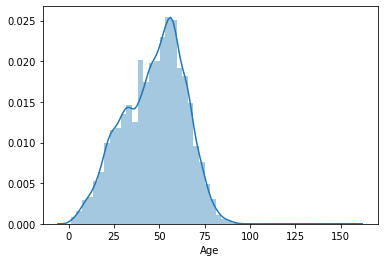

In [149]:
sns.distplot(final_df['Age'])


The distribution of "Age" of the patients is tending towards a Normal Distribution 

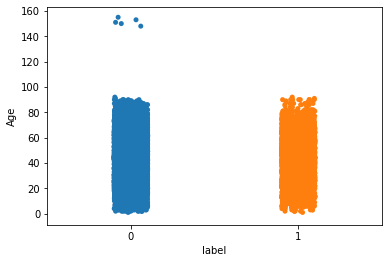

In [150]:
sns.stripplot(final_df['label'], final_df['Age'])

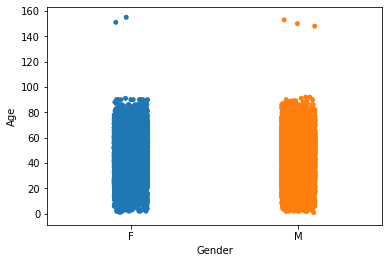

In [151]:
sns.stripplot(final_df['Gender'], final_df['Age'])

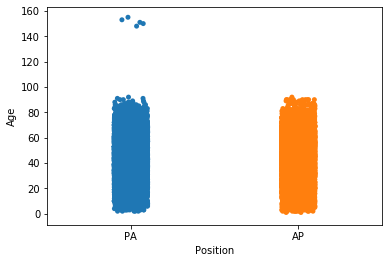

In [152]:
sns.stripplot(final_df['Position'], final_df['Age'])

- From the above plots it is clear that there are five patients whose age is more than 100 and having 'PA' position of X-ray  are outliers for the model


In [153]:
final_df[final_df['Age'] >= 100]

,patientId,Age,Gender,Position,dicom,class,label,boxes
3175,3b8b8777-a1f6-4384-872a-28b95f59bf0d,148,M,PA,./stage_2_train_images/3b8b8777-a1f6-4384-872a...,Normal,0,[]
9708,73aeea88-fc48-4030-8564-0a9d7fdecac4,151,F,PA,./stage_2_train_images/73aeea88-fc48-4030-8564...,No Lung Opacity / Not Normal,0,[]
15273,a4e8e96d-93a6-4251-b617-91382e610fab,153,M,PA,./stage_2_train_images/a4e8e96d-93a6-4251-b617...,No Lung Opacity / Not Normal,0,[]
23374,ec3697bd-184e-44ba-9688-ff8d5fbf9bbc,150,M,PA,./stage_2_train_images/ec3697bd-184e-44ba-9688...,Normal,0,[]
24537,f632328d-5819-4b29-b54f-adf4934bbee6,155,F,PA,./stage_2_train_images/f632328d-5819-4b29-b54f...,Normal,0,[]


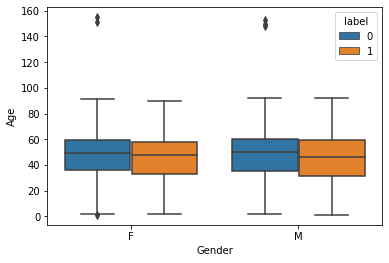

In [154]:

sns.boxplot(final_df['Gender'], final_df['Age'], hue = final_df['label'] )

Target variable is not biased towards Gender

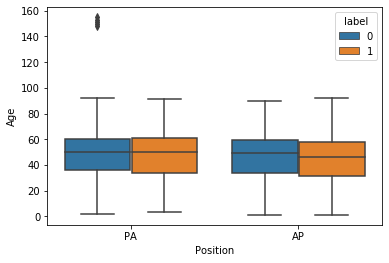

In [155]:
sns.boxplot(final_df['Position'], final_df['Age'], hue = final_df['label'] )

Getting Feauture Distribution

In [0]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))



In [157]:
get_feature_distribution(final_df, 'class')

Feature: class
No Lung Opacity / Not Normal  :   11821 or 44.29%
Normal                        :   8851 or 33.16%
Lung Opacity                  :   6012 or 22.53%


In [158]:
get_feature_distribution(final_df, 'Position')

Feature: Position
PA                            :   14511 or 54.38%
AP                            :   12173 or 45.61%


In [159]:
get_feature_distribution(final_df, 'Gender')

Feature: Gender
M                             :   15166 or 56.83%
F                             :   11518 or 43.16%


Plotting for Number of Examinations for each class

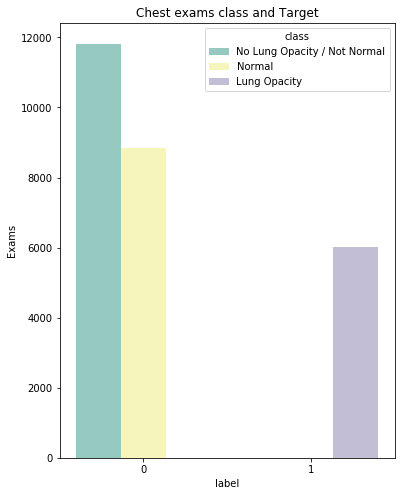

In [160]:
fig, ax = plt.subplots(nrows=1,figsize=(6,8))
tmp = final_df.groupby('label')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'label', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()


### P value calculations

In [0]:
#calculating P-values of these variables
final_df_dcm = final_df.loc[:,['Age','Gender','Position','class','label']]

In [173]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
final_df_dcm.head()


,Age,Gender,Position,class,label
0,51,F,PA,No Lung Opacity / Not Normal,0
1,48,F,PA,No Lung Opacity / Not Normal,0
2,19,M,AP,No Lung Opacity / Not Normal,0
3,28,M,PA,Normal,0
4,32,F,AP,Lung Opacity,1


In [0]:
from sklearn.preprocessing import OneHotEncoder
labelencoder = LabelEncoder()
final_df_dcm.iloc[:,1] = labelencoder.fit_transform(final_df_dcm.iloc[:,1])
final_df_dcm.iloc[:,2] = labelencoder.fit_transform(final_df_dcm.iloc[:,2])  
final_df_dcm.iloc[:,3] = labelencoder.fit_transform(final_df_dcm.iloc[:,3]) 
                                                                      

In [0]:
onehotencoder = OneHotEncoder()
final_df_dcm.iloc[:,1] = labelencoder.fit_transform(final_df_dcm.iloc[:,1])
final_df_dcm.iloc[:,2] = labelencoder.fit_transform(final_df_dcm.iloc[:,2])  
final_df_dcm.iloc[:,3] = labelencoder.fit_transform(final_df_dcm.iloc[:,3]) 

In [177]:
final_df_dcm

,Age,Gender,Position,class,label
0,51,0,1,1,0
1,48,0,1,1,0
2,19,1,0,1,0
3,28,1,1,2,0
4,32,0,0,0,1
...,...,...,...,...,...
26679,47,0,0,0,1
26680,54,1,0,0,1
26681,46,0,1,2,0
26682,45,1,1,2,0


In [0]:
pvalue_arr = np.asarray(final_df_dcm)
pvalue_arr[0]

array([51,  0,  1,  1,  0])

In [0]:
import statsmodels.api as sm
target = pvalue_arr[:,4]
p_age = pvalue_arr[:,0]
p_position = pvalue_arr[:,2]
p_gender = pvalue_arr[:,1]
p_class = pvalue_arr[:,3]
regressor_OLS_age = sm.OLS(endog = target, exog = p_age ).fit()
regressor_OLS_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.188
Model:                            OLS   Adj. R-squared (uncentered):              0.188
Method:                 Least Squares   F-statistic:                              6165.
Date:                Sat, 25 Jan 2020   Prob (F-statistic):                        0.00
Time:                        21:02:34   Log-Likelihood:                         -15206.
No. Observations:               26684   AIC:                                  3.041e+04
Df Residuals:                   26683   BIC:                                  3.042e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0041   5.24e-05     78.514      0.000       0.004       0.004
==============================================================================
Omnibus:                     4533.691   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7219.293
Skew:                           1.268   Prob(JB):                         0.00
Kurtosis:                       2.752   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
regressor_OLS_position = sm.OLS(endog = target,exog = p_position ).fit()
regressor_OLS_position.summary()                                                                                                                                        

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.021
Model:                            OLS   Adj. R-squared (uncentered):              0.021
Method:                 Least Squares   F-statistic:                              567.6
Date:                Sat, 25 Jan 2020   Prob (F-statistic):                   3.71e-124
Time:                        21:12:15   Log-Likelihood:                         -17698.
No. Observations:               26684   AIC:                                  3.540e+04
Df Residuals:                   26683   BIC:                                  3.541e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0929      0.004     23.824      0.000       0.085       0.101
==============================================================================
Omnibus:                     4677.291   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7514.923
Skew:                           1.293   Prob(JB):                         0.00
Kurtosis:                       2.723   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
regressor_OLS_class = sm.OLS(target,p_class).fit()
regressor_OLS_class.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                              0.000
Date:                Sat, 25 Jan 2020   Prob (F-statistic):                        1.00
Time:                        21:17:52   Log-Likelihood:                         -17979.
No. Observations:               26684   AIC:                                  3.596e+04
Df Residuals:                   26683   BIC:                                  3.597e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1                  0      0.002          0      1.000      -0.004       0.004
==============================================================================
Omnibus:                     4779.910   Durbin-Watson:                   1.429
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7772.188
Skew:                           1.315   Prob(JB):                         0.00
Kurtosis:                       2.729   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
regressor_OLS_gender = sm.OLS(target,p_gender).fit()
regressor_OLS_gender.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.135
Model:                            OLS   Adj. R-squared (uncentered):              0.135
Method:                 Least Squares   F-statistic:                              4169.
Date:                Sat, 25 Jan 2020   Prob (F-statistic):                        0.00
Time:                        21:24:17   Log-Likelihood:                         -16042.
No. Observations:               26684   AIC:                                  3.209e+04
Df Residuals:                   26683   BIC:                                  3.210e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2314      0.004     64.566      0.000       0.224       0.238
==============================================================================
Omnibus:                     4117.514   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6283.645
Skew:                           1.182   Prob(JB):                         0.00
Kurtosis:                       2.756   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

CLASS variable has P value of more than threshold of 0.025 and other variables have ‘ZERO’ P-value.  Therefore, class variable is not taken to the model basing on this statistical analysis


Density plot of Bounding Box Co-ordinates

<Figure size 432x288 with 0 Axes>

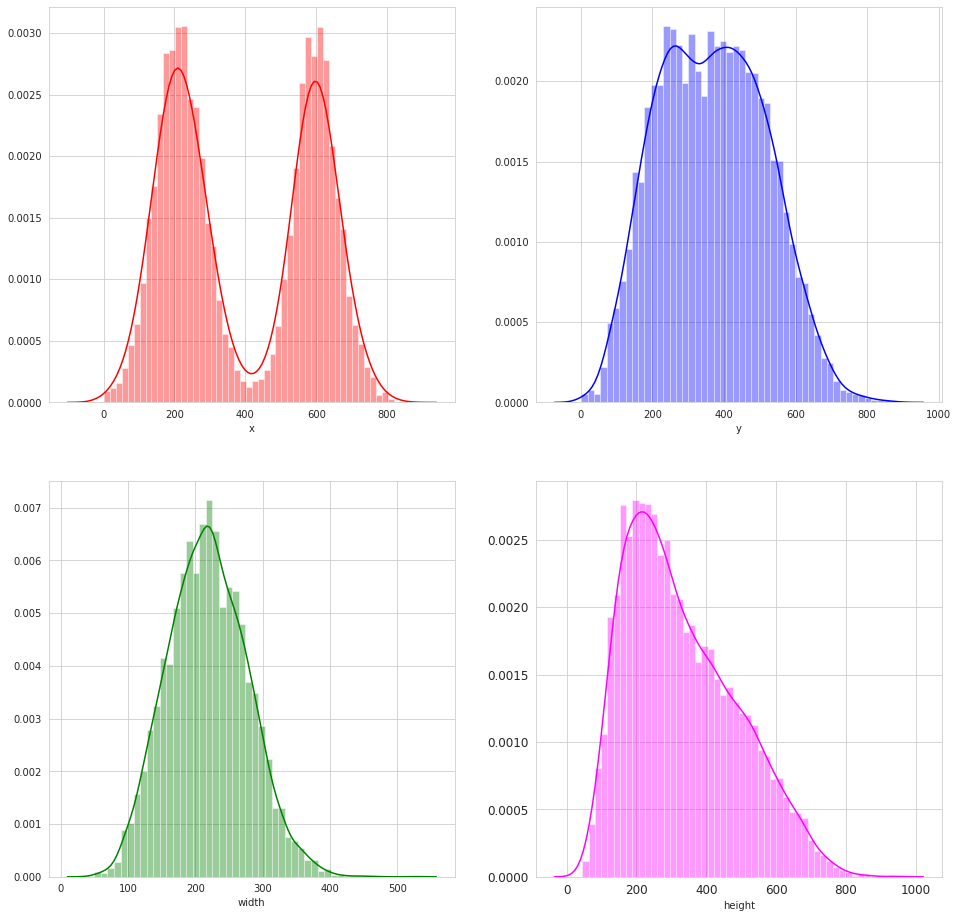

In [0]:
target1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(16,16))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Plotting centers of Lung Opacity Rectangles

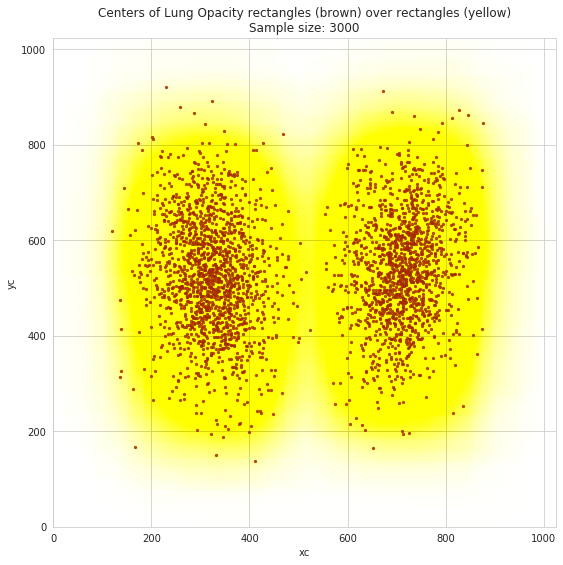

In [0]:
fig, ax = plt.subplots(1,1,figsize=(9,9))
target_sample = target1.sample(3000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 3000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

In [0]:
corr = data_train_labels.corr()
corr

,x,y,width,height,Target,Age,Rows,Columns,SamplesPerPixel
x,1.000000,0.007604,-0.058665,0.008256,NaN,-0.016081,NaN,NaN,NaN
y,0.007604,1.000000,-0.299897,-0.645369,NaN,0.104195,NaN,NaN,NaN
width,-0.058665,-0.299897,1.000000,0.597461,NaN,0.027666,NaN,NaN,NaN
height,0.008256,-0.645369,0.597461,1.000000,NaN,-0.006048,NaN,NaN,NaN
Target,NaN,NaN,NaN,NaN,1.000000,-0.056878,NaN,NaN,NaN
Age,-0.016081,0.104195,0.027666,-0.006048,-0.056878,1.000000,NaN,NaN,NaN
Rows,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Columns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SamplesPerPixel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# DISPLAYING DCOM IMAGES

In [0]:
def show_dicom_images(data):
  patientlist = data['index']
  for i in range(len(patientlist)):
    Patient = data['index'][i]
    age = data['Age'][i]
    sex = data['Gender'][i]
    position = data['Position'][i]
    data_img = data['dicom'][i]
    data_row_img = pydicom.read_file(data_img)
    plt.imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
    plt.axis('off')
    plt.title('ID: {}\nPostition: {}, Age: {}, Sex: {}, Target: {}\nClass: {}'.format(
                Patient, position, age, sex, data['label'][i], data['class'][i]))
    plt.show()

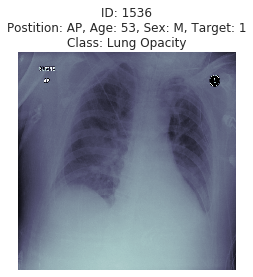

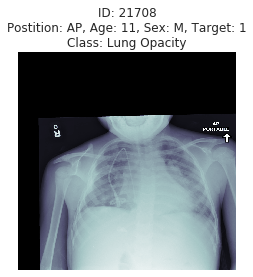

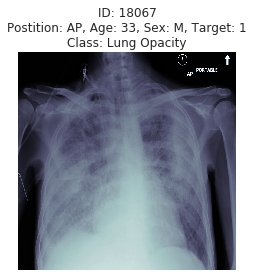

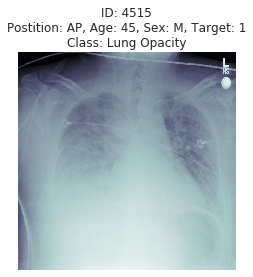

In [0]:
show_dicom_images(final_df[final_df['label']==1].sample(4).reset_index())

### Show healthy DCOM Images

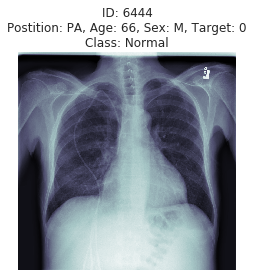

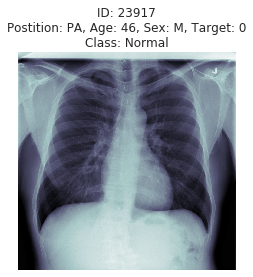

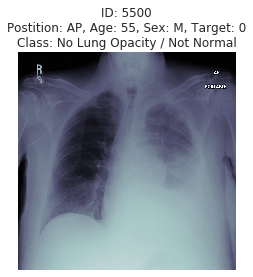

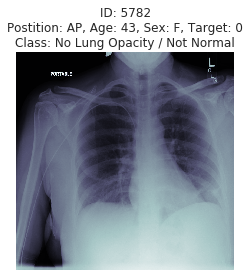

In [0]:
show_dicom_images(final_df[final_df['label']==0].sample(4).reset_index())

# DRAWING THE X-RAY OF PATIENT WITH BOUDNING BOXES

In [0]:
# Method to draw singel patient if bounding boxes are present
def draw_with_bounding_box(data):
    
    # Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    plt.imshow(im)

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    #  Convert coordinates to integers
    box = [int(b) for b in box]
    
    #  Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

### STUDYING DIFFERENT KINDS OF X-RAYS

- Normal X-ray

003d8fa0-6bf1-40ed-b54c-ac657f8495c5
Label of Patient is 0


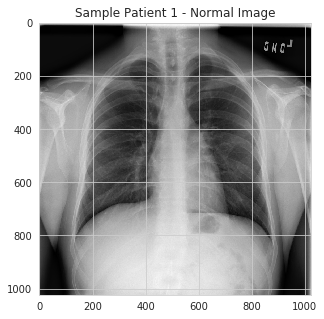

In [0]:
patientId = train_labels_df['patientId'][3]
print(patientId)
print('Label of Patient is {}'.format(final_df.loc[2]['label']))

plt.figure(figsize=(5,5))
plt.title("Sample Patient 1 - Normal Image")

draw_with_bounding_box(Patient_data[patientId])

- LUNG OPACITY

00704310-78a8-4b38-8475-49f4573b2dbb
Label of Patient is 1


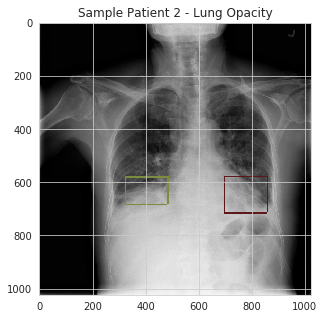

In [0]:
patientId = train_labels_df['patientId'][8]
print(patientId)
print('Label of Patient is {}'.format(final_df.loc[7]['label']))

plt.figure(figsize=(5,5))
plt.title("Sample Patient 2 - Lung Opacity")

draw_with_bounding_box(Patient_data[patientId])
               

**Understanding Opacity** :
Usually the lungs are full of air. When someone has pneumonia, the air in the lungs is replaced by other material - fluids, bacteria, immune system cells, etc. That's why areas of opacities are areas that are grey but should be more black. When we see them we understand that the lung tissue in that area is probably not healthy.

**Opacity** - Opacity is a pretty loose term - "Opacity refers to any area that preferentially attenuates the x-ray beam and therefore appears more opaque than the surrounding area. It is a nonspecific term that does not indicate the size or pathologic nature of the abnormality" - from Felson's Principles of Chest Roentgenology (Fourth Edition).

**Meaning** - Any area in the chest radiograph that is more white than it should be. If you compare the images of Sample Patient 1 and Sample Patient 2 you can see that the lower boundry of the lungs of patient 2 is obscured by opacities. In the image of Sample Patient 1 you can see the clear difference between the black lungs and the tissue below it, and in the image of Sample Patient 2 there is just this fuzziness.

- NO Lung OPACITY/NOT NORMAL

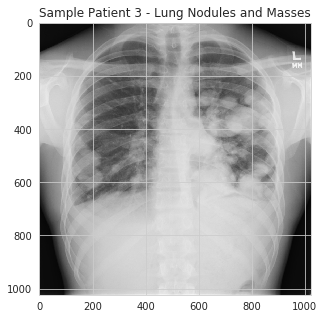

In [0]:
patientId = train_labels_df['patientId'][2]
#print(patient_class.loc[patientId])

plt.figure(figsize=(5,5))
plt.title("Sample Patient 3 - Lung Nodules and Masses")
draw_with_bounding_box(Patient_data[patientId])

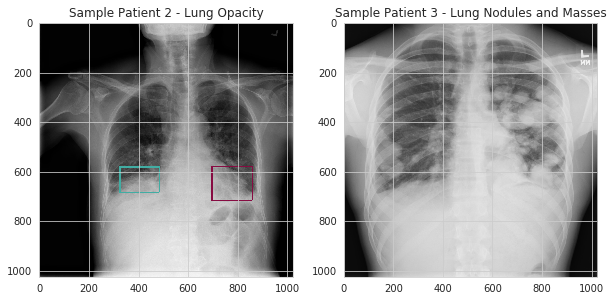

In [0]:
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.title("Sample Patient 2 - Lung Opacity")
draw_with_bounding_box(Patient_data[train_labels_df['patientId'][8]])

plt.subplot(122)
plt.title("Sample Patient 3 - Lung Nodules and Masses")
draw_with_bounding_box(Patient_data[train_labels_df['patientId'][2]])

The main difference in the types of opacities between these two patient sample2 and patient sample3 is the borders and the shape of the opacity, Patient 3 has multiple round and clearly defined opacities. Patient 2 has this poorly defined haziness which obscures the margins of the lungs and heart. This haziness is termed **consolidation.**

- **Ground Glass Opacity and Consolidation**

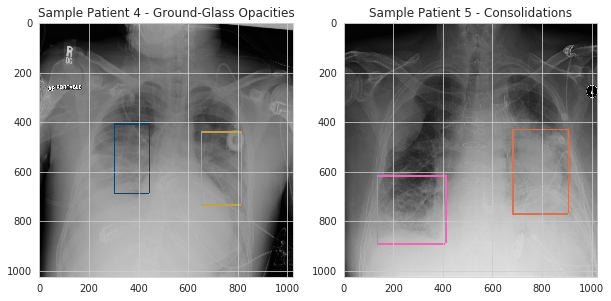

In [0]:
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.title("Sample Patient 4 - Ground-Glass Opacities")
draw_with_bounding_box(Patient_data[train_labels_df['patientId'][25]])
#print(patient_class.loc[df['patientId'][25]])

plt.subplot(122)
plt.title("Sample Patient 5 - Consolidations")
draw_with_bounding_box(Patient_data[train_labels_df['patientId'][28]])
#print(patient_class.loc[df['patientId'][28]])

**Patient 4 - Ground-Glass Opacities**: We can see that the lungs are "whiter" than they should be, but we can see most of the borders of the lungs and heart. Ground-Glass Opacity definition - *"On chest radiographs, ground-glass opacity appears as an area of hazy increased lung opacity, usually extensive, within which margins of pulmonary vessels may be indistinct. [...] Ground-glass opacity is less opaque than consolidation, in which bronchovascular margins are obscured."

**Patient 5 - Consolidations**: There are fuzzy areas in the lungs and the borders of the lungs and heart cannot be seen. Consolidation definition - *"Consolidation appears as a homogeneous increase in pulmonary parenchymal attenuation that obscures the margins of vessels and airway walls."

- **OPACITIES THAT ARE NOT LINKED TO PNEUMONIA**

- Lung Nodules and Masses

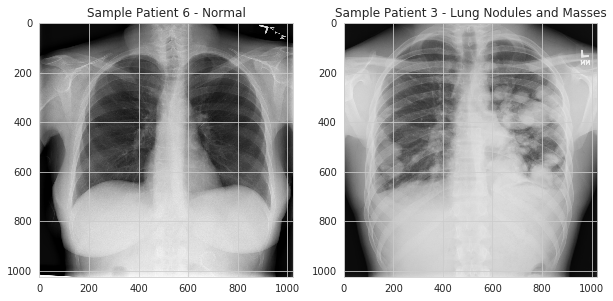

In [0]:
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.title("Sample Patient 6 - Normal")
draw_with_bounding_box(Patient_data[train_labels_df['patientId'][59]])


plt.subplot(122)
plt.title("Sample Patient 3 - Lung Nodules and Masses")
draw_with_bounding_box(Patient_data[train_labels_df['patientId'][2]])
#print(class_info_df.loc[train_labels_df['patientId'][2]])

- Plural Effusion

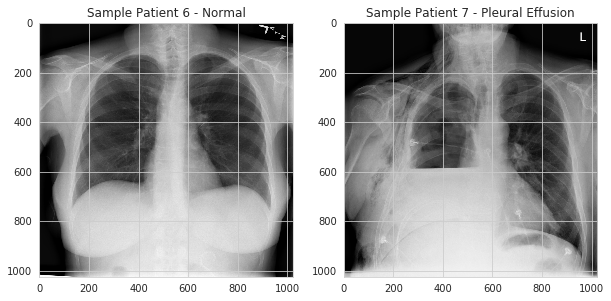

In [0]:
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.title("Sample Patient 6 - Normal")
draw_with_bounding_box(Patient_data[train_class_df['patientId'][59]])
#print(patient_class.loc[df['patientId'][59]])

plt.subplot(122)
plt.title("Sample Patient 7 - Pleural Effusion")
draw_with_bounding_box(Patient_data[train_class_df['patientId'][125]])
#print(patient_class.loc[df['patientId'][125]])



The lower part of the right lung of Patient 7 (the right lung is at the left side of the picture) is higher than in a normal image. This is a called a pleural effusion. It is caused by an accumulation of fluid in the chest outside of the lung. This causes the lung to look smaller on the chest radiograph.

- Increased Vascular Markings + Enlarged Heart



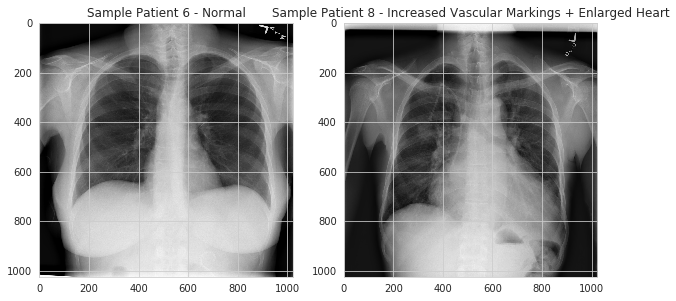

In [0]:
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.title("Sample Patient 6 - Normal")
draw_with_bounding_box(Patient_data[train_labels_df['patientId'][59]])
#print(patient_class.loc[df['patientId'][59]])

plt.subplot(122)
plt.title("Sample Patient 8 - Increased Vascular Markings + Enlarged Heart")
draw_with_bounding_box(Patient_data[train_labels_df['patientId'][38]])
#print(patient_class.loc[df['patientId'][38]])

- White Lung

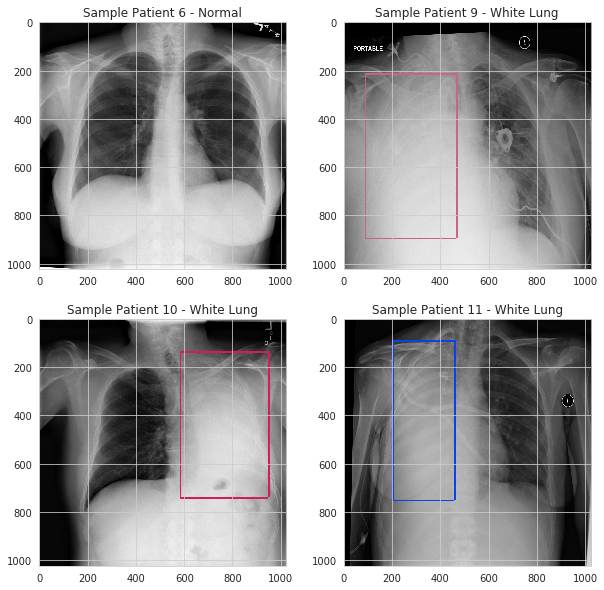

In [0]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.title("Sample Patient 6 - Normal")
draw_with_bounding_box(Patient_data[train_labels_df['patientId'][59]])
#print(train_class_df['patientId'][59]])

plt.subplot(222)
plt.title("Sample Patient 9 - White Lung")
draw_with_bounding_box(Patient_data['924f4f8b-fc27-4dfd-b5ae-59c40715e150'])
#print(patient_class.loc['924f4f8b-fc27-4dfd-b5ae-59c40715e150'])

plt.subplot(223)
plt.title("Sample Patient 10 - White Lung")
draw_with_bounding_box(Patient_data['17a5ce04-809a-42ed-9e58-100cfb33de7a'])
#print(patient_class.loc['17a5ce04-809a-42ed-9e58-100cfb33de7a'])

plt.subplot(224)
plt.title("Sample Patient 11 - White Lung")
draw_with_bounding_box(Patient_data['9dde630b-1f95-46e6-bcde-117eee4c7283'])
#print(patient_class.loc['9dde630b-1f95-46e6-bcde-117eee4c7283'])